In [22]:
from scipy.stats import kde
import h5py
import astropy.io.fits as fits
import csv
import pandas as pd
import numpy as np
import tables
import pickle
import os
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import incredible as cr
from scipy.special import erf
from scipy import stats
import scipy.optimize as opt
from scipy import stats
import scipy.optimize as opt
import emcee
import tqdm
import pickle
from astropy import table
from astropy.table import Table, join, unique
from specutils import SpectralRegion
from scipy.interpolate import BSpline, make_interp_spline, UnivariateSpline

In [23]:
from astropy.cosmology import FlatLambdaCDM
from scipy.interpolate import interp1d
import numpy as np
import astropy.units as u
import astropy.cosmology.units as cu
from astropy.cosmology import Planck18
from astropy.cosmology import z_at_value
cosmo = Planck18

## Functions for computing spectroscopic richness and profiles
from projection_functions import *

In [24]:
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt


plot_params = {

'axes.linewidth': 1.25,
'xtick.major.width': 1, 'ytick.major.width': 1,
'xtick.minor.width': 1, 'ytick.minor.width': 1,
'xtick.major.size': 12, 'ytick.major.size': 12,
'xtick.labelsize': 12, 'ytick.labelsize': 12,
'xtick.direction': 'in', 'ytick.direction': 'in',
'xtick.major.pad': 6, 'xtick.minor.pad': 6,
'figure.constrained_layout.use': True,
#'text.usetex': True,
'font.family': 'Serif',
'font.size': 14,
'legend.fontsize': 11
    
}
plt.rcParams.update(plot_params)

## Importing Catalogs and applying cuts

In [25]:
with open('bgs_clus_RM_gal_matched.pickle', 'rb') as handle:
    bgs_matched = pickle.load(handle)

bgs_matched.columns

<TableColumns names=('TARGETID','RA_BGS','DEC_BGS','Z_BGS','WEIGHT','flux_g_dered','flux_r_dered','flux_z_dered','flux_w1_dered','flux_w2_dered','ID','LAMBDA','Z_LAMBDA','R_LAMBDA','Z_SPEC_x','RA_x','DEC_x','MODEL_MAG_R_x','MODEL_MAGERR_R_x','RM_gal_flag','Z_SPEC_y','RA_y','DEC_y','R','P','MODEL_MAG_R_y','MODEL_MAGERR_R_y','geoFrac')>

In [26]:
fcols = ['g','r','z','w1','w2']
for col in fcols:
    #bgs_matched['flux_'+col.lower()+'_dered'] = bgs_matched['FLUX_'+col]/data['MW_TRANSMISSION_'+col]
    bgs_matched['r_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_r_dered'])
    bgs_matched['g_dered'] = 22.5 - 2.5*np.log10(bgs_matched['flux_g_dered'])
    bgs_matched['gmr'] = bgs_matched['g_dered']-bgs_matched['r_dered']

In [27]:
#binGap = 1e-5
wide_bin_1 = np.linspace(-0.1,-0.005,21, endpoint=False)
small_bin = np.linspace(-0.005,0.005,21, endpoint=False)
micro_bin = np.linspace(-0.005,0.005,31)
wide_bin_2 = np.linspace(0.005,0.1,21, endpoint=False)


binBoundaries = np.hstack((wide_bin_1, small_bin))
binBoundaries = np.hstack((binBoundaries, wide_bin_2))
binCent = np.asarray([(binBoundaries[i] + binBoundaries[i+1])/2 for i in range(len(binBoundaries)-1)])
binCent_micro = np.asarray([(micro_bin[i] + micro_bin[i+1])/2 for i in range(len(micro_bin)-1)])
bin_width = np.asarray([binBoundaries[i+1]-binBoundaries[i] for i in range(len(binBoundaries[:-1]))])

## None overlapping bins
assert len(set(binCent)) == len(binCent), "Overlapping bins"
assert len(set(binBoundaries)) == len(binBoundaries), "Overlapping bins"

## Binning 

In [28]:
#Bin by richness
lmda_bins = [[20,22],[22,25],[25,30],[30,40],[40,60],[60,200]] #upper limit must match lower limit of next bin
## Bin by redshift
z_bins = [[0.1,0.2],[0.2,0.3],[0.3,0.4]]

lmda_bin_edges = np.logspace(np.log10(20), np.log10(100),11)
lmda_bins = [[lmda_bin_edges[i], lmda_bin_edges[i+1]] for i in range(len(lmda_bin_edges)-1)]

##Create an absolute magnitude column
cosmo = Planck18
h = 0.67
M_r = bgs_matched['r_dered']-cosmo.distmod(bgs_matched['Z_BGS']).value - 5*np.log10(h)
bgs_matched['M_r'] = M_r ##comoving M with h-scaling

##Cuts
bgs_matched = bgs_matched[np.where(bgs_matched['r_dered'] < 19.5)]
#bgs_matched = bgs_matched[np.where(bgs_matched['Z_BGS']< 0.3)]
#bgs_matched = bgs_matched[np.where(bgs_matched['M_r'] < 22)]
#bgs_matched = bgs_matched[np.where(bgs_matched['LAMBDA'] > 100)]

## Binned Measurements

* All
* Binned by luminosity
* Redshift
* Outlier removal (sigma-clipping)
* Confidence bands.
* Plot scatter plot compare with Gaussian. 

In [29]:
### Plotting params
smoothing_param = 0
xlim_inset_low = -0.005; xlim_inset_high = 0.005
xlim_low = -0.1; xlim_high = 0.1
ylim_low = 1; ylim_high = 1e4
ylim_inset_low = 10; ylim_inset_high = 1e4
z_anchor = 0.4
shift_wide_val = 0.0002
shift_small_val = 0.0001
fontsize=14
alpha=0.5

In [30]:
import bces.bces as BCES
from scipy.optimize import curve_fit
from scipy.stats.distributions import chi2

# Define your fitting function
def loglinear_function(x, m, c):
    return m * np.log10(x) + c

'''
Fitting using Bivariate Correlated Errors and Intrinsic Scatter (BCES). Need to take into account covariance!
'''
def linear_fit(x, y, xerr, yerr, verbose=False):
    logx = np.log10(lambda_rm_list)
    logy = np.log10(lambda_true_list)
    logxerr = lambda_rm_err_list/(lambda_rm_list*np.log(10))
    logyerr = lambda_true_err_list/(lambda_true_list*np.log(10))
    cov = np.zeros_like(lambda_rm_list)
    #cov = np.ones_like(lambda_rm_list)*np.cov(x,y)[1,0] # Covariance between xerr and yerr (set to zeros if uncorrelated)

    # Perform BCES regression
    a, b, aerr, berr, covab = BCES.bcesp(logx, logxerr, logy, logyerr, cov)
    
    # 'a' and 'b' contain the best-fit parameters (slope and intercept) for different BCES lines.
    # 'aerr' and 'berr' are their respective standard deviations.
    # 'covab' is the covariance between 'a' and 'b'.
    
    # For example, to access the OLS(Y|X) results (index 0):
    slope_ols_yx = a[0]
    intercept_ols_yx = b[0]
    slope_err_ols_yx = aerr[0]
    intercept_err_ols_yx = berr[0]

    if verbose:
        print(f"OLS(Y|X) Slope: {slope_ols_yx:.2f} +/- {slope_err_ols_yx:.2f}")
        print(f"OLS(Y|X) Intercept: {intercept_ols_yx:.2f} +/- {intercept_err_ols_yx:.2f}")

    return  slope_ols_yx, intercept_ols_yx, slope_err_ols_yx, intercept_err_ols_yx

'''
For correlated errors on x and y for linear fit. Need to take into account covariance!
'''
def compute_chisq(x, y, xerr, yerr, slope, intercept, verbose=False):
    # Calculate the effective variance for each point with covariance
    logx = np.log10(lambda_rm_list)
    logy = np.log10(lambda_true_list)
    logxerr = lambda_rm_err_list/(lambda_rm_list*np.log(10))
    logyerr = lambda_true_err_list/(lambda_true_list*np.log(10))
                                   
    df_dlogx_at_x = slope #Derivative at each x_data point 
    df_dx_at_x = 10**intercept *(slope)*x**(slope-1)
    effective_variance = (logyerr**2 + (df_dlogx_at_x * logxerr)**2) #+ np.ones_like(xerr)*2*np.cov(logx,logy)[1,0] #* y * np.log(10) 
    #effective_variance = (yerr**2 + (df_dx_at_x * xerr)**2) #+ np.ones_like(xerr)*2*np.cov(x,y)[1,0]
    
    # Calculate the chi-squared statistic
    #y_fitted = np.log10(10**intercept * x**slope)
    logy_fitted = slope*logx + intercept
    chi_squared = np.sum((logy - logy_fitted)**2 /effective_variance)
    
    # Degrees of freedom (N - number of parameters)
    degrees_of_freedom = len(x) - 2
    p_value = chi2.sf(chi_squared, degrees_of_freedom)

    if verbose:
        print(f"Chi-squared statistic: {chi_squared:.3f}")
        print(f"Degrees of freedom: {degrees_of_freedom}")
        print(f"P-value using sf: {p_value}")
    
    return chi_squared, degrees_of_freedom, p_value

## Apply simultaneuous absolute magnitude and redshit cuts
| Redshift| Magnitude |
|-----|-----|
| $z\in[0.1,0.2)$ | -19.8|
| $z\in[0.2,0.3)$ | -20.8 |
| $z\in[0.3,0.4)$ | -21.5 |


In [31]:
zDict = {
           r'$z \in [0.10,0.20)$':np.asarray((bgs_matched['Z_SPEC_x'] >= 0.10) & (bgs_matched['Z_SPEC_x'] < 0.20)), \
           r'$z \in [0.20,0.30)$':np.asarray((bgs_matched['Z_SPEC_x'] >= 0.20) & (bgs_matched['Z_SPEC_x'] < 0.30)), \
           r'$z \in [0.30,0.40)$':np.asarray((bgs_matched['Z_SPEC_x'] >= 0.30) & (bgs_matched['Z_SPEC_x'] < 0.40))
          }

#fmtList = ['h', 'o', 'D', '*']

MagDict = {
           r'$ M_r < -19.8$': np.asarray((bgs_matched['M_r'] <-19.8)), \
           r'$ M_r < -20.8$': np.asarray((bgs_matched['M_r'] <-20.8)), \
           r'$ M_r < -21.5$': np.asarray((bgs_matched['M_r'] <-21.5)), 
          }

#MagDict = [ {k1:MagDict[k1], 'fmt':k2} for k1, k2 in zip(MagDict, fmtList)]

In [32]:
##Valid indices -- see table
validInd = [[0,0],[1,1],[2,2]]

combinedDict = {}
for i, (key1, val1) in enumerate(MagDict.items()):
    for j, (key2, val2) in enumerate(zDict.items()):
        if any([i,j] == sublist for sublist in validInd):
            name = key1 + ' ' + key2
            val = val1 & val2 ##Boolean logic
            combinedDict[name] = val

        else:
            continue

#print(combinedDict)
#combinedDict.update({"All":np.full(len(bgs_matched), True)})

## Plotting trends

/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/global/homes/z/zzhang13/.conda/envs/myEnv_v39/lib/python3.9/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


BCES, 10000 trials... 
1.233632 s
Chi-squared statistic: 22.862
Degrees of freedom: 8
P-value using sf: 0.003545440202270384
BCES, 10000 trials... 
1.239227 s
Chi-squared statistic: 26.005
Degrees of freedom: 8
P-value using sf: 0.001048313900102484
BCES, 10000 trials... 
1.241383 s
Chi-squared statistic: 16.338
Degrees of freedom: 8
P-value using sf: 0.0377944083835018


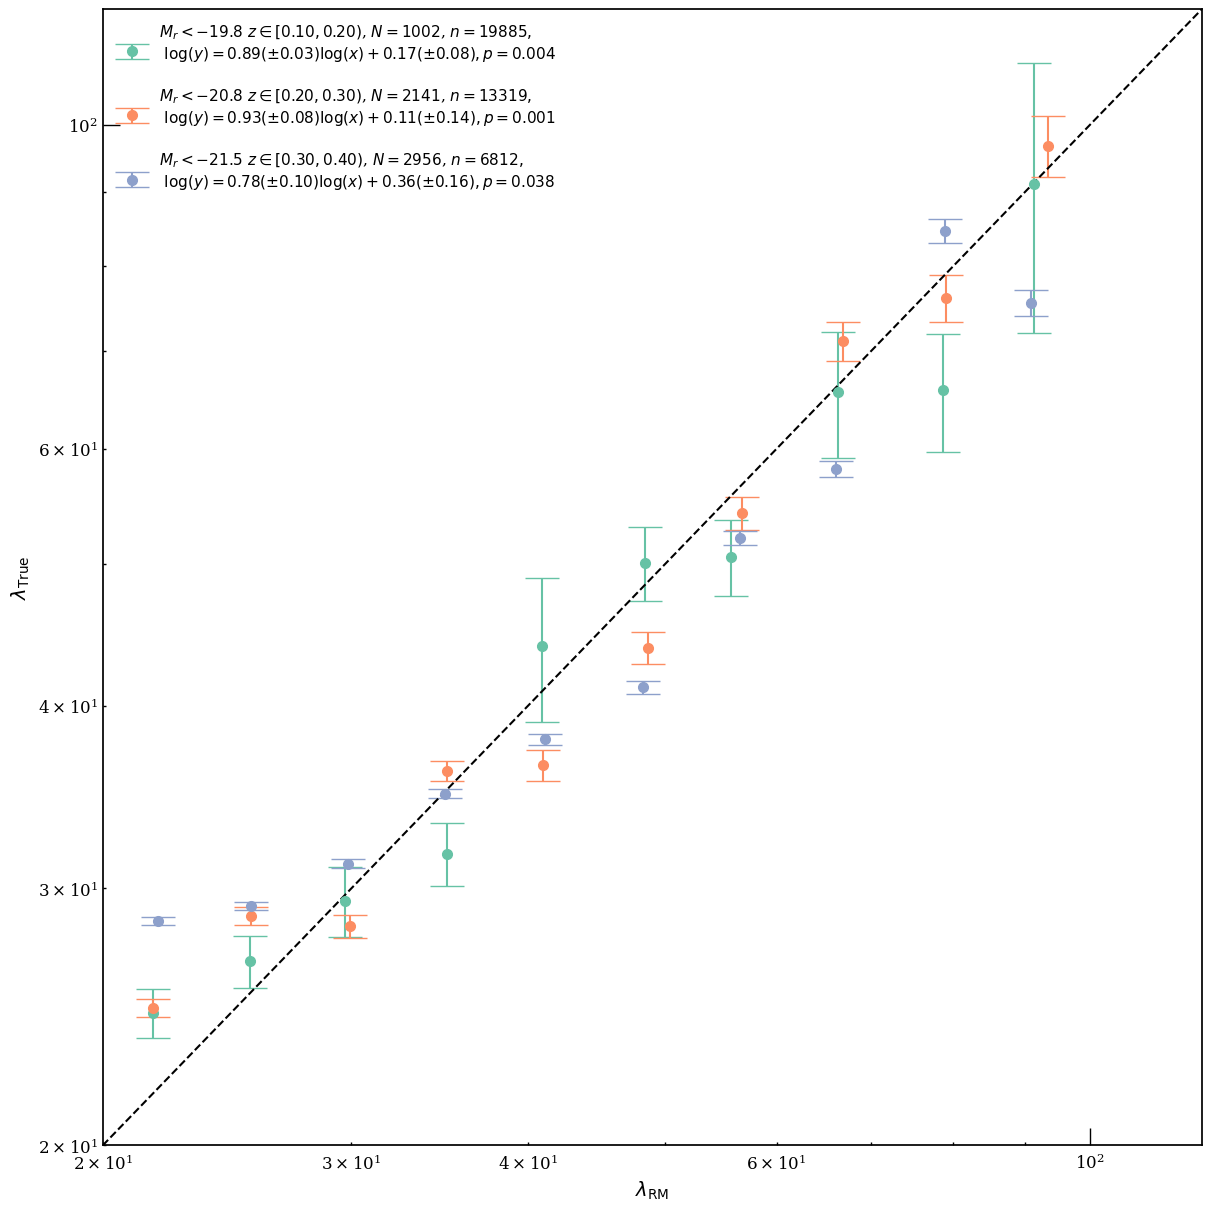

In [49]:
from scipy import stats
fig, ax = plt.subplots(figsize=(12,12))
xlow = 20; xhigh = 120
xline = np.linspace(xlow, xhigh,1000)
cmap = plt.get_cmap('Set2')
color_ind = 0


xshift = 1
for key, val in combinedDict.items():
    
    cutTable = bgs_matched[val]
    numTotal = len(cutTable)
    numCluster = len(np.unique(cutTable['ID']))

    lambda_true_list = []
    lambda_rm_list = []
    lambda_rm_err_list = []
    lambda_true_err_list = []
    numList = []
    for i, lmda_bin in enumerate(lmda_bins):
        #for j, z_bin in enumerate(z_bins):
            #cut &=(bgs_matched['Z_SPEC_x'] >= z_bin[0]) & (bgs_matched['Z_SPEC_x'] < z_bin[1])
            ##Apply binning
        cut = (cutTable['LAMBDA'] >= lmda_bin[0]) & (cutTable['LAMBDA'] < lmda_bin[1])
            
        binnedTable = cutTable[cut]
        lambda_tot, lambda_true, lambda_true_err = calc_specRichness_stacked(binBoundaries, binCent, binnedTable)
        #numCluster = len(np.unique(binnedTable['ID']))
        
        #lambda_true_err *= 1./np.sqrt(numCluster)
        lambda_rm_list = np.hstack((lambda_rm_list, np.mean(binnedTable['LAMBDA'])))  
        lambda_rm_err_list = np.hstack((lambda_rm_err_list, stats.sem(binnedTable['LAMBDA'])))  
        lambda_true_err_list = np.hstack((lambda_true_err_list, lambda_true_err))  
        lambda_true_list = np.hstack((lambda_true_list,lambda_true))   
        numList = np.hstack((numList,len(unique(binnedTable, keys='ID'))))



    ##Linear fitting
    slope, intercept, slope_err, intercept_err = linear_fit(lambda_rm_list, lambda_true_list, lambda_rm_err_list, lambda_true_err_list)
    chi_squared, degrees_of_freedom, p_value = compute_chisq(lambda_rm_list, lambda_true_list, lambda_rm_err_list, lambda_true_err_list, slope, intercept, verbose=True)
    

    #best_fit_label = r'$\log(y)={:.2f}(\pm {:.2f})\log(x) {:+.2f}(\pm {:.2f}), p={:.3f}$'.format(slope, slope_err, intercept, intercept_err, p_value)
    label = key + ', ' + r'$N={:d}$'.format(numCluster) + r', $n={:d}$'.format(numTotal) + ', ' + best_fit_label

    ##Set pivot point to 40
    bias = np.log10(40)*(1-slope)-intercept
    intercept += bias
    y_fitted = 10**intercept * lambda_rm_list**slope

    best_fit_label = r'$\log(y)={:.2f}(\pm {:.2f})\log(x) {:+.2f}(\pm {:.2f}), p={:.3f}$'.format(slope, slope_err, intercept, intercept_err, p_value)
    label = key + ', ' + r'$N={:d}$'.format(numCluster) + r', $n={:d},$'.format(numTotal) + '\n ' + best_fit_label + '\n'
    
    #xshift *=1.02
    #ax.plot(lambda_rm_list, y_fitted, color=cmap(color_ind))
    ax.errorbar(lambda_rm_list*xshift, lambda_true_list*10**bias, yerr = lambda_true_err_list, \
                linestyle='none', label=label, capsize=12, ms=7, color=cmap(color_ind), fmt='o')
    color_ind +=1
    #xshift *=1.02

ax.plot(xline,xline,color='black', linestyle='dashed')   
ax.set_xlabel(r'$\lambda_{\rm RM}$')

ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([20,30,50,70,100,150])
ax.set_yticks([5,10,20,30,50,100,300])
ax.set_ylabel(r'$\lambda_{\rm True}$')
ax.set_xscale('log'); 
ax.set_yscale('log')
ax.set_xlim([xlow, xhigh]); 
ax.set_ylim([xlow, xhigh])
plt.legend(frameon=False, loc='best')
plt.savefig('lambda_spec_lambda_rm_binned.jpeg')
plt.show()